In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install ruptures
import ruptures as rpt

from google.colab import drive
drive.mount('/content/drive')

!pip install Google-Colab-Transfer
import colab_transfer

colab_path = colab_transfer.get_path_to_home_of_local_machine()
drive_path = colab_transfer.get_path_to_home_of_google_drive()

input_folder_name = ['data/cleaned']

for name in input_folder_name:
  colab_transfer.copy_folder(
      folder_name=name,
      source=drive_path,
      destination=colab_path,
  )

     |████████████████████████████████| 921kB 13.6MB/s 
Mounted at /content/drive
Copying /content/drive/My Drive/data/cleaned to /content/data/cleaned


In [ ]:
wifiData = pd.read_pickle('/content/data/cleaned/' + 'wifi_ap_data.pkl')

fumehood = pd.read_pickle('/content/data/cleaned/fumehoodFlow.pkl')
waterMeter = pd.read_pickle('/content/data/cleaned/waterMeter.pkl')
securityEvents = pd.read_pickle("/content/data/cleaned/securityEvents.pkl")
lighting = pd.read_pickle("/content/data/cleaned/lightingOccSensors.pkl")
sound = pd.read_pickle("/content/data/cleaned/soundLevelSensor.pkl")
tvoc = pd.read_pickle("/content/data/cleaned/tvocSensors.pkl")
freezers = pd.read_pickle("/content/data/cleaned/freezers.pkl")
co2 = pd.read_pickle("/content/data/cleaned/co2Sensors.pkl")


# Change Point Detection (Clayton)

## Wifi

In [ ]:
wifiData

External                    True                           ... False              
Floor                           3                       2  ...     4             5
Room                          300     384     361     201  ...   460       481 581
AP                        300_Ext 384_Ext 361_Ext 201_Ext  ...  460n 460sw 481 581
ts                                                         ...                    
2020-04-30 17:00:00-07:00     NaN     NaN     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:05:00-07:00     NaN     1.0     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:10:00-07:00     NaN     1.0     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:15:00-07:00     NaN     NaN     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:20:00-07:00     NaN     NaN     1.0     NaN  ...   NaN   NaN NaN NaN
...                           ...     ...     ...     ...  ...   ...   ...  ..  ..
2021-05-05 16:35:00-07:00     NaN     2.0     NaN     1.0  ...   NaN   1.0 NaN NaN
2021-05-05 16:40:00-07:00     1.0     3.0     1.0     1.0  ...   NaN   1.0 NaN NaN
2021-05-05 16:45:00-07:00     NaN     2.0     1.0     NaN  ...   NaN   1.0 NaN NaN
2021-05-05 16:50:00-07:00     NaN     2.0     NaN     NaN  ...   NaN   1.0 NaN NaN
2021-05-05 16:55:00-07:00     NaN     2.0     1.0     NaN  ...   NaN   1.0 NaN NaN

[106560 rows x 65 columns]

In [ ]:
wifiTotals = wifiData.sum(axis=1)
wifiTotals = wifiTotals.replace(0, np.nan)
wifiTotals = wifiTotals.fillna(method='ffill')
wifiTotals.index = wifiTotals.index.tz_localize(None)

In [ ]:
offset = wifiTotals.index.get_loc("2020-06-22 12:00")
wifiTotals.index.values[offset]
wifiTotals[offset]

ts
2020-06-22 12:00:00    87.0
dtype: float64

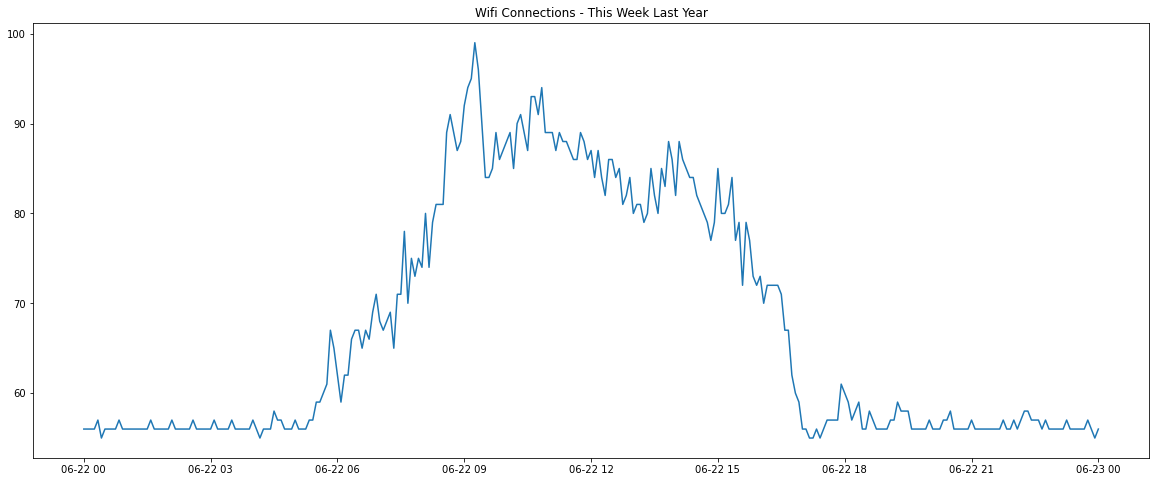

In [ ]:
plt.figure(figsize = (20,8))
plt.title("Wifi Connections - This Week Last Year")
plt.plot(wifiTotals["2020-6-22 00:00":"2020-6-23 00:00"])

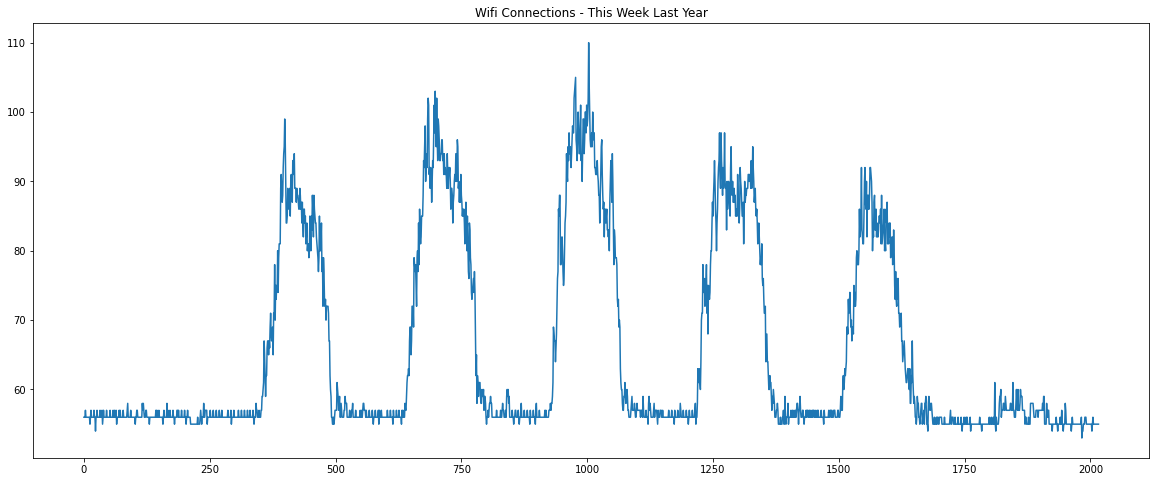

In [ ]:
points = np.array(wifiTotals["2020-6-21 00:00":"2020-6-28 00:00"])

plt.figure(figsize = (20,8))
plt.title("Wifi Connections - This Week Last Year")
plt.plot(points)

In [ ]:
startTimes = []
endTimes = []

points = np.array(wifiTotals["2020-6-21 00:00":"2020-6-28 00:00"])
offset = wifiTotals.index.get_loc("2020-6-21 0:00")

# Binary segmentation search method, RBF segment model
model = "rbf"  
algo = rpt.Binseg(model=model).fit(points)
bkps_i = algo.predict(n_bkps=10)[:10]
bkps_ts = wifiTotals.index.values[bkps_i + offset]

for i, ts in enumerate(bkps_ts):
  if i % 2 == 0: startTimes.append(ts)
  else: endTimes.append(ts)



[numpy.datetime64('2020-06-22T05:35:00.000000000'),
 numpy.datetime64('2020-06-23T05:45:00.000000000'),
 numpy.datetime64('2020-06-24T05:55:00.000000000'),
 numpy.datetime64('2020-06-25T06:30:00.000000000'),
 numpy.datetime64('2020-06-26T06:15:00.000000000')]

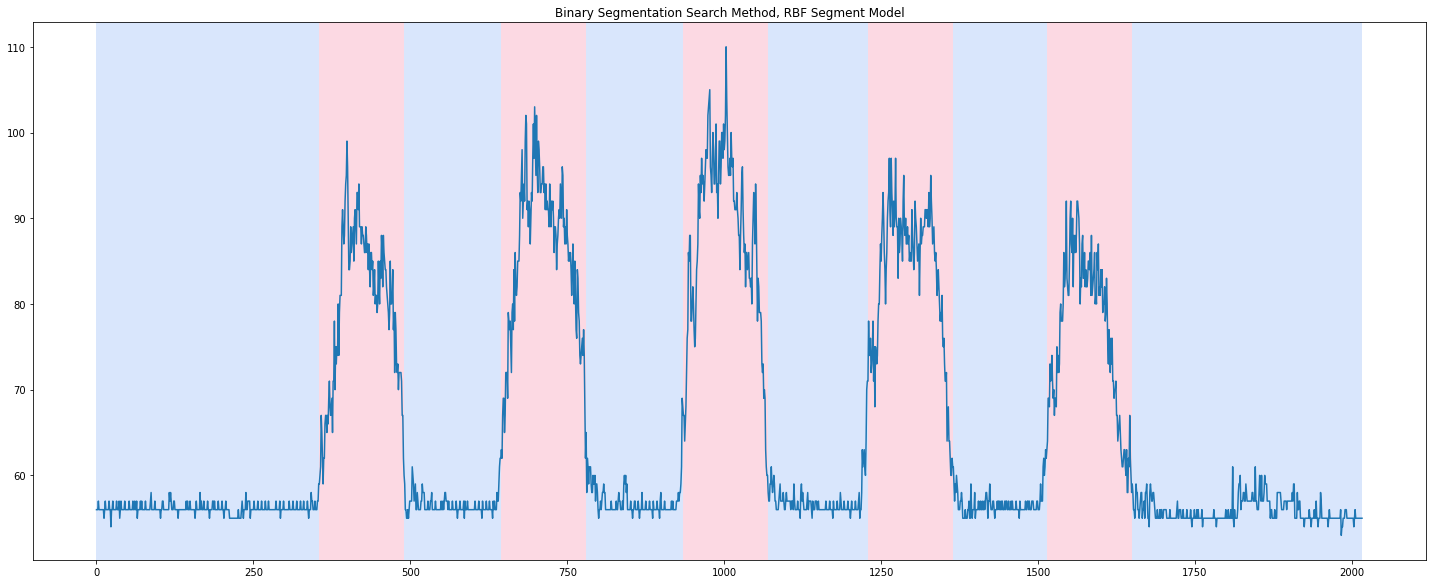

In [ ]:
# Binary segmentation search method, RBF segment model
model = "rbf"  
algo = rpt.Binseg(model=model).fit(points)
bkps_i = algo.predict(n_bkps=10)
bkps_ts = wifiTotals.index.values[bkps_i + offset][:10]

# Show results
rpt.show.display(points, bkps_i, figsize=(20, 8))
plt.title('Binary Segmentation Search Method, RBF Segment Model')
plt.show()

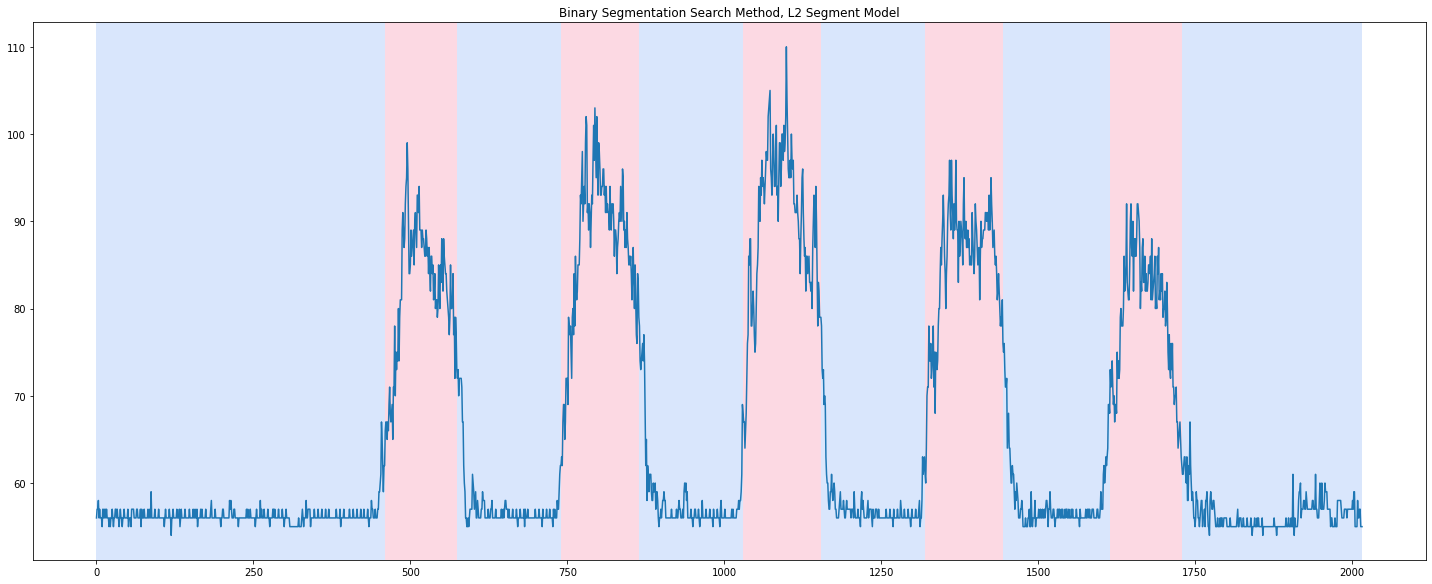

In [ ]:
# Binary segmentation search method, L2 segment model
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Binary Segmentation Search Method, L2 Segment Model')
plt.show()

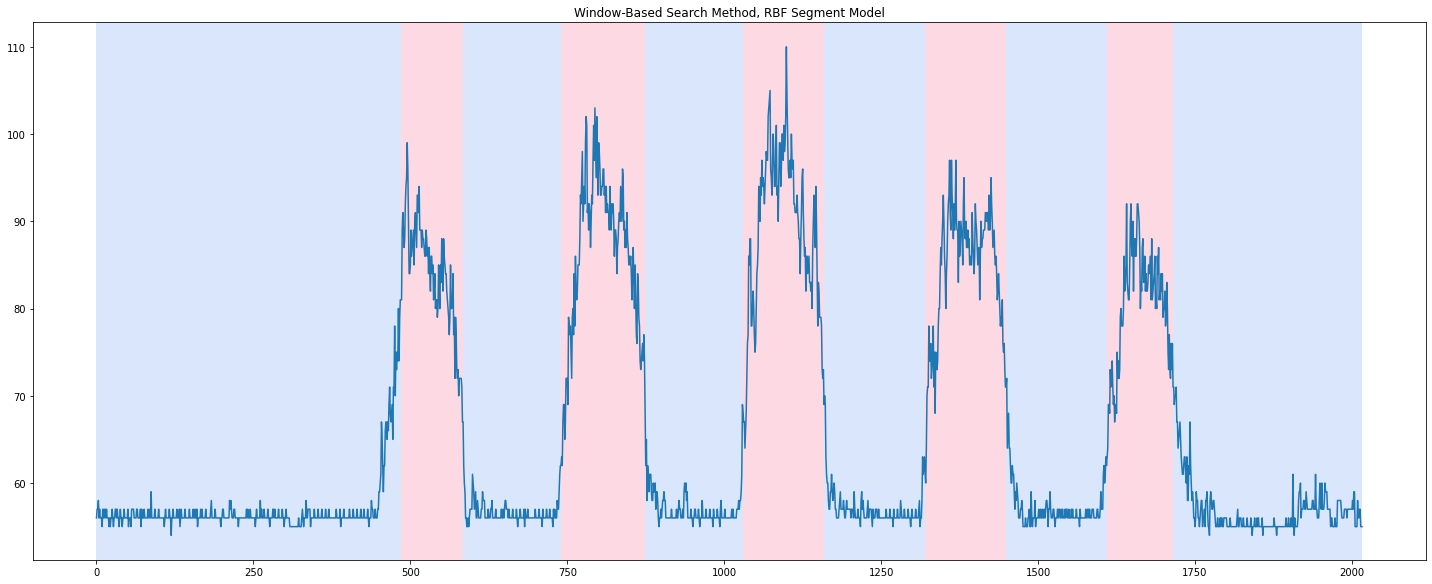

In [ ]:
# Window-based search method, RBF segment model
model = "rbf"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Window-Based Search Method, RBF Segment Model')
plt.show()

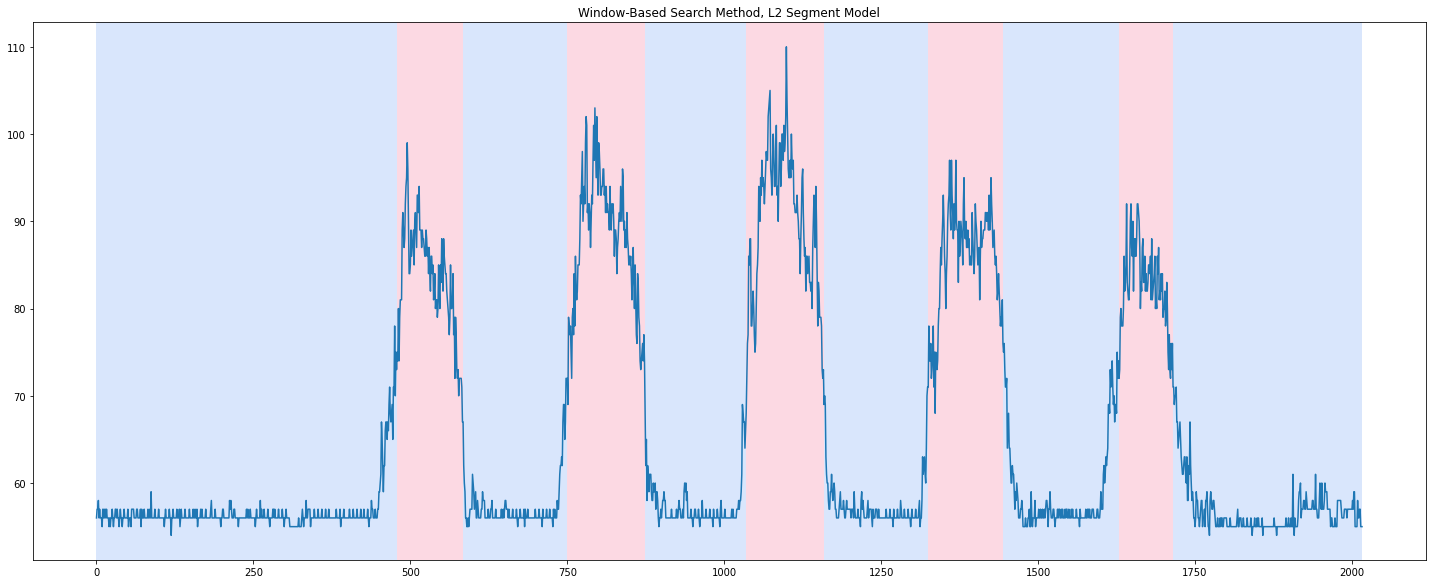

In [ ]:
# Window-based search method, L2 segment model
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Window-Based Search Method, L2 Segment Model')
plt.show()

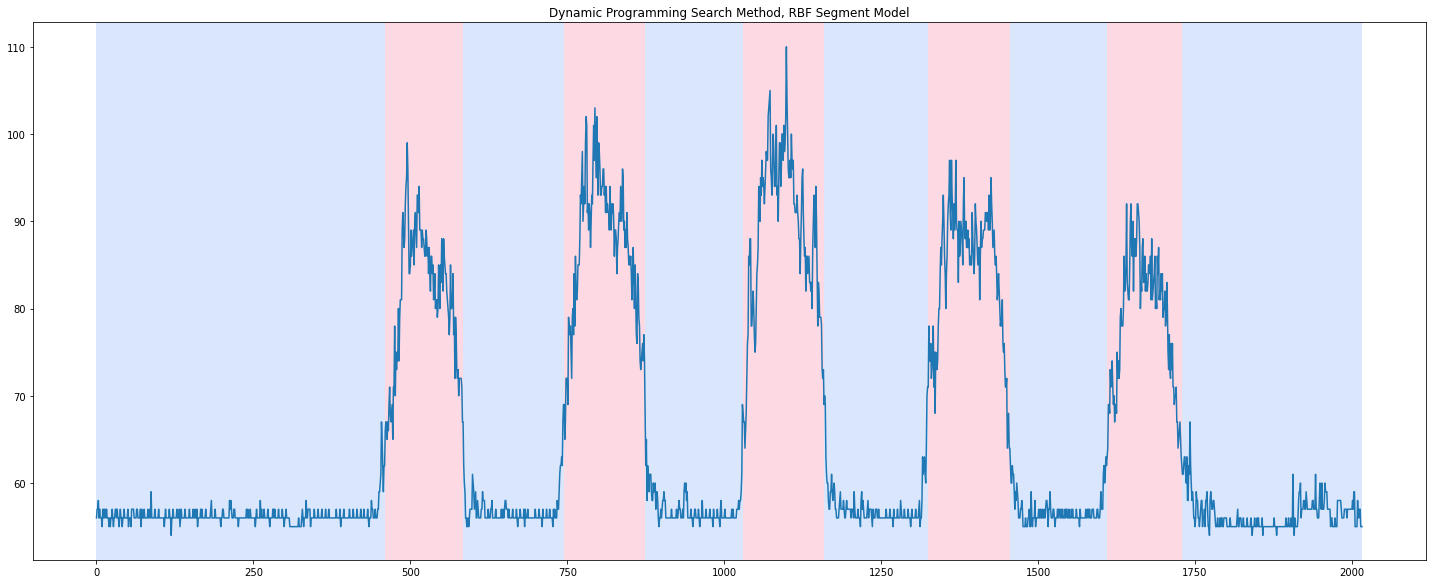

In [ ]:
# Dynamic programming search method
model = "rbf"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Dynamic Programming Search Method, RBF Segment Model')
plt.show()

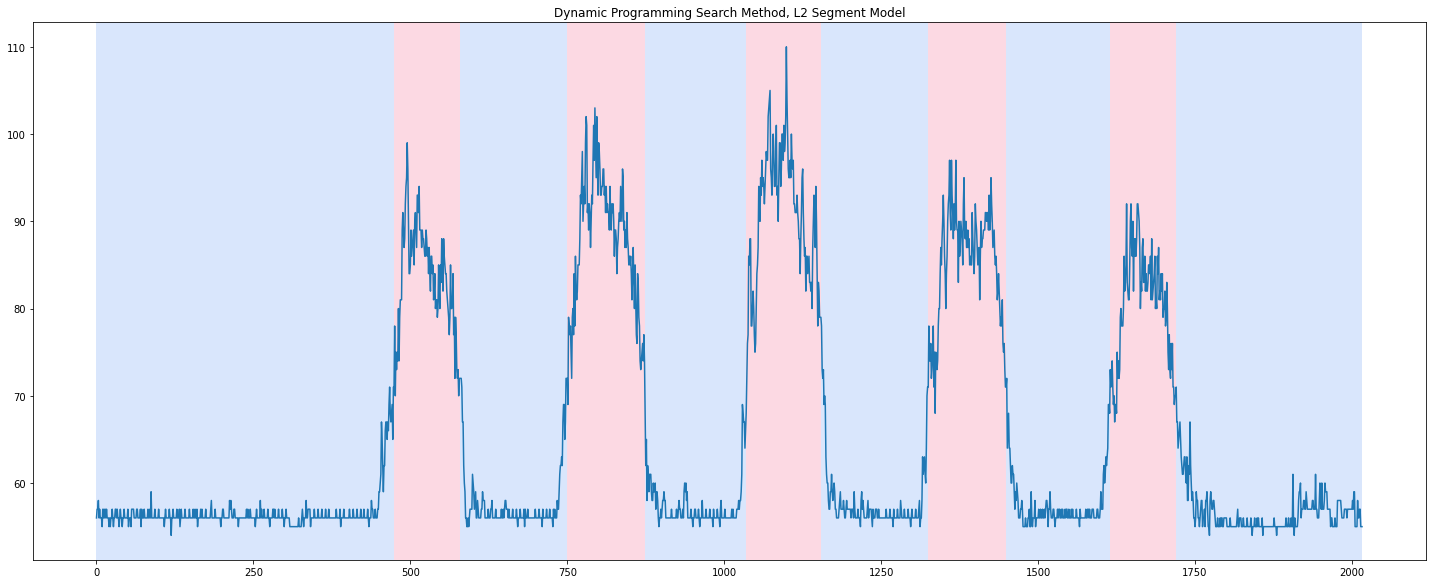

In [ ]:
# Dynamic programming search method, L2 segment model
model = "l2"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Dynamic Programming Search Method, L2 Segment Model')
plt.show()

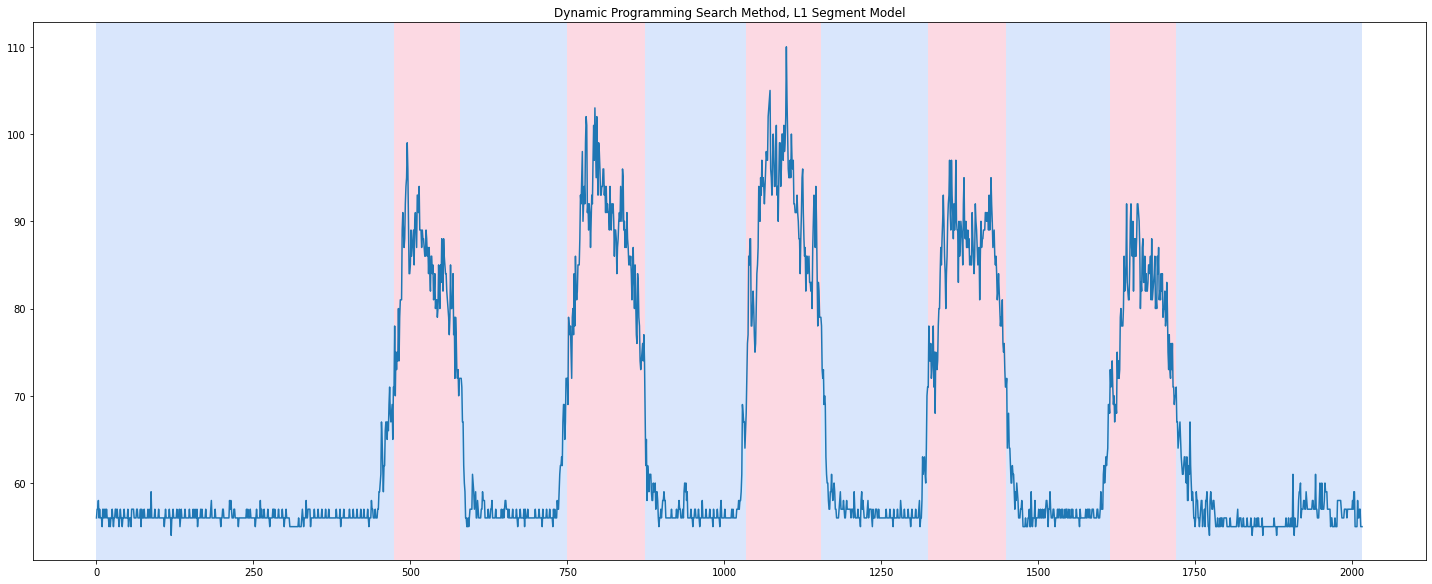

In [ ]:
# Dynamic programming search method, L1 segment model
model = "l1"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Dynamic Programming Search Method, L1 Segment Model')
plt.show()

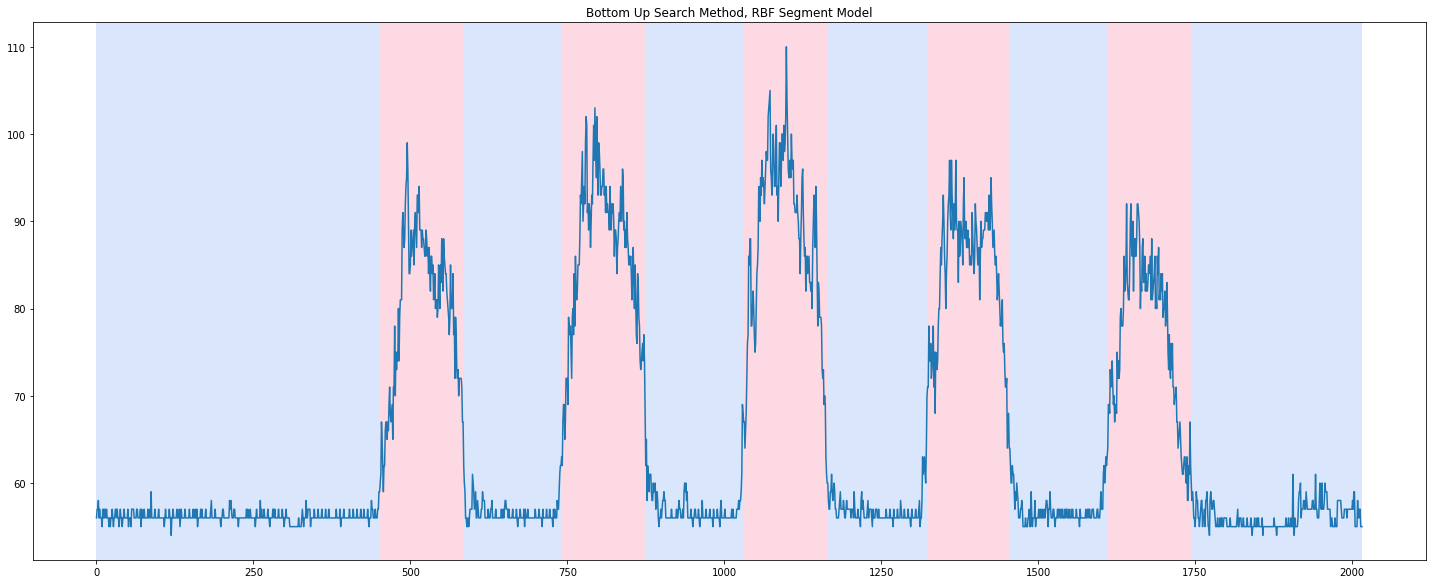

In [ ]:
# Bottom up search method, RBF segment model
model = "rbf"
algo = rpt.BottomUp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Bottom Up Search Method, RBF Segment Model')
plt.show()

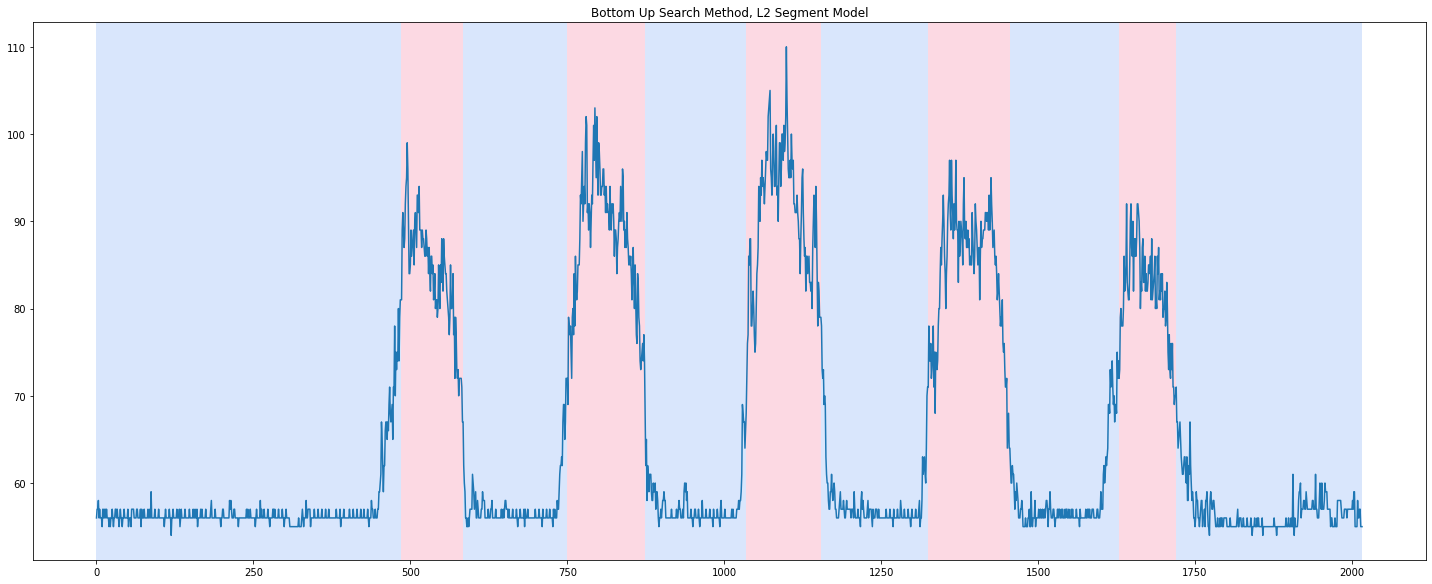

In [ ]:
# Bottom up search method, L2 segment model
model = "l2"
algo = rpt.BottomUp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Bottom Up Search Method, L2 Segment Model')
plt.show()

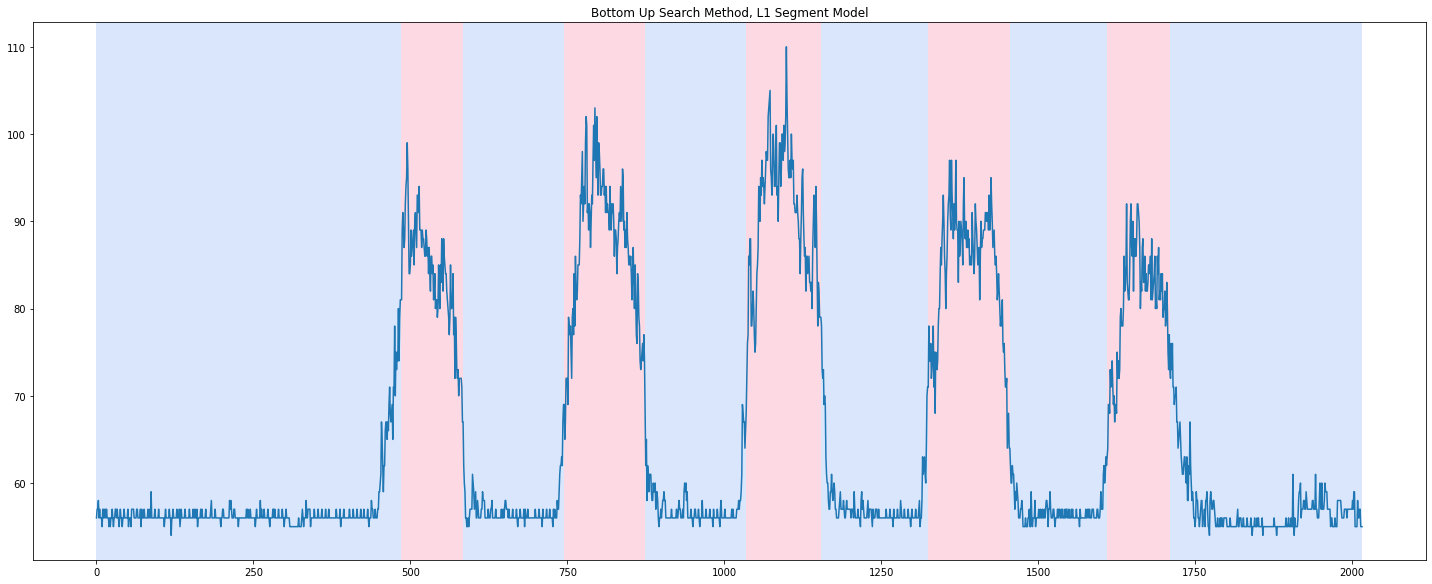

In [ ]:
# Bottom up search method, L1 segment model
model = "l1"
algo = rpt.BottomUp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Bottom Up Search Method, L1 Segment Model')
plt.show()

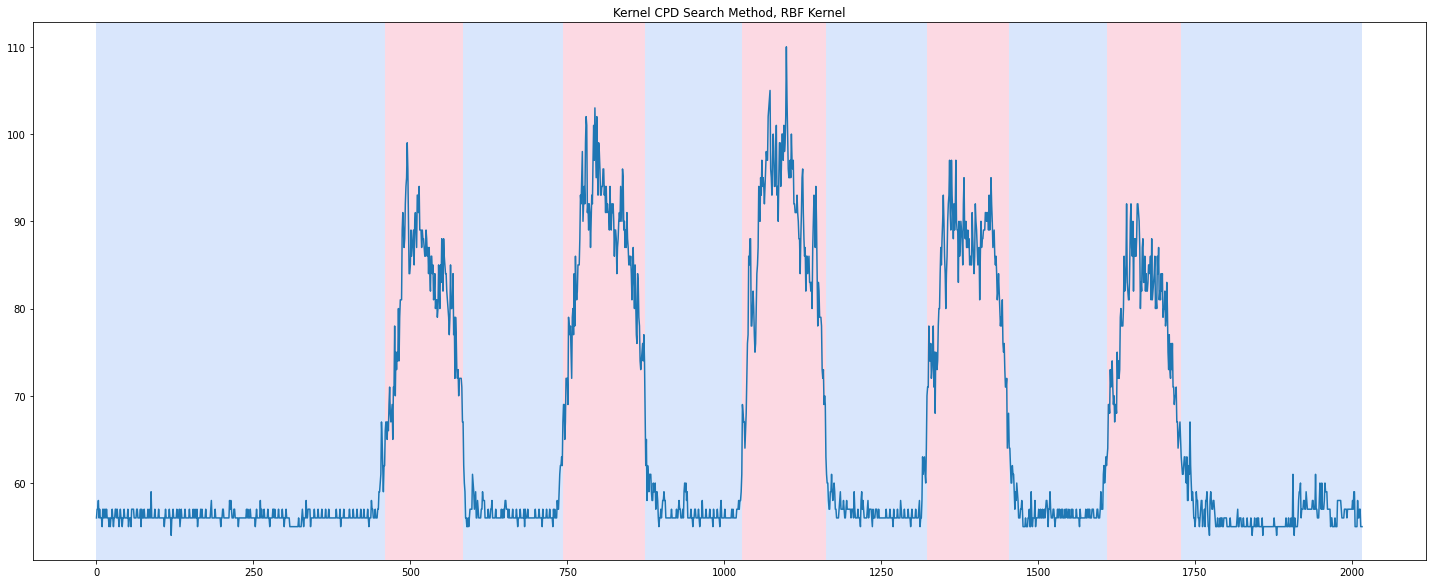

In [ ]:
# Kernel CPD search method, RBF kernel
kernel = "rbf"
algo = rpt.KernelCPD(kernel=kernel, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Kernel CPD Search Method, RBF Kernel')
plt.show()

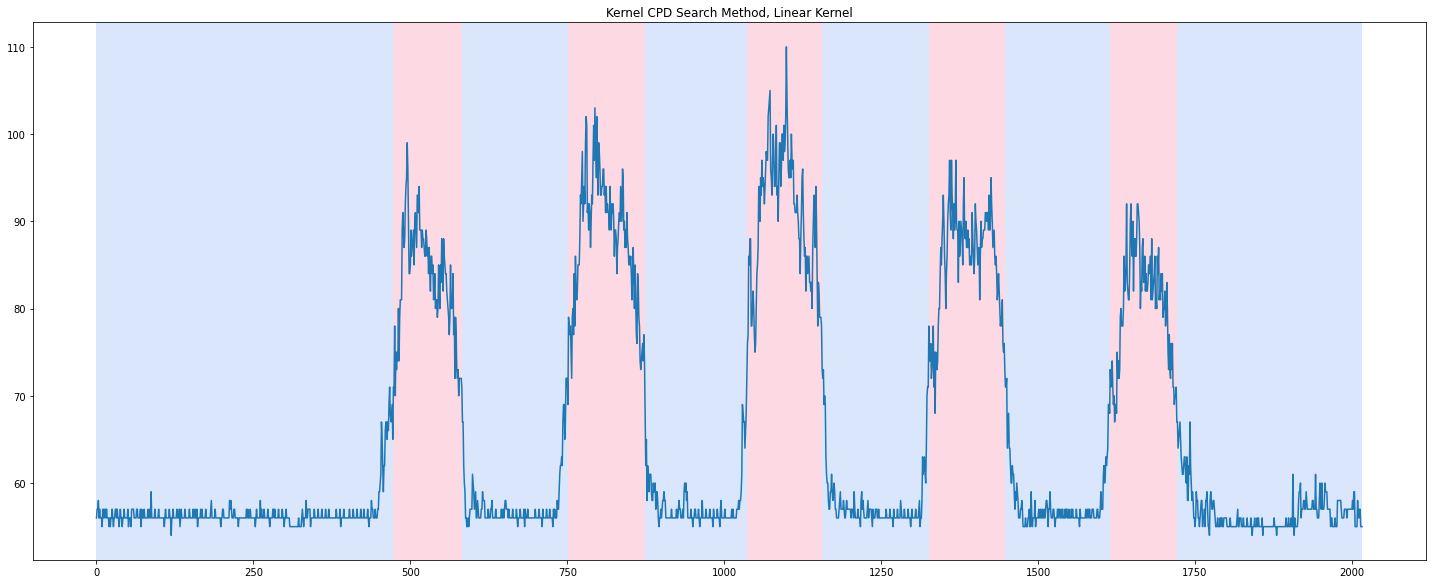

In [ ]:
# Kernel CPD search method, Linear kernel
kernel = "linear"
algo = rpt.KernelCPD(kernel=kernel, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(20, 8))
plt.title('Kernel CPD Search Method, Linear Kernel')
plt.show()

# EDA and Cleaning (Ryan)

## Wifi

In [ ]:
wifiData

External                    True                           ... False              
Floor                           3                       2  ...     4             5
Room                          300     384     361     201  ...   460       481 581
AP                        300_Ext 384_Ext 361_Ext 201_Ext  ...  460n 460sw 481 581
ts                                                         ...                    
2020-04-30 17:00:00-07:00     NaN     NaN     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:05:00-07:00     NaN     1.0     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:10:00-07:00     NaN     1.0     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:15:00-07:00     NaN     NaN     1.0     NaN  ...   NaN   NaN NaN NaN
2020-04-30 17:20:00-07:00     NaN     NaN     1.0     NaN  ...   NaN   NaN NaN NaN
...                           ...     ...     ...     ...  ...   ...   ...  ..  ..
2021-05-05 16:35:00-07:00     NaN     2.0     NaN     1.0  ...   NaN   1.0 NaN NaN
2021-05-05 16:40:00-07:00     1.0     3.0     1.0     1.0  ...   NaN   1.0 NaN NaN
2021-05-05 16:45:00-07:00     NaN     2.0     1.0     NaN  ...   NaN   1.0 NaN NaN
2021-05-05 16:50:00-07:00     NaN     2.0     NaN     NaN  ...   NaN   1.0 NaN NaN
2021-05-05 16:55:00-07:00     NaN     2.0     1.0     NaN  ...   NaN   1.0 NaN NaN

[106560 rows x 65 columns]

In [ ]:
wifiTotals = wifiData.sum(axis=1)
wifiTotals = wifiTotals.replace(0, np.nan)
wifiTotals = wifiTotals.fillna(method='ffill')

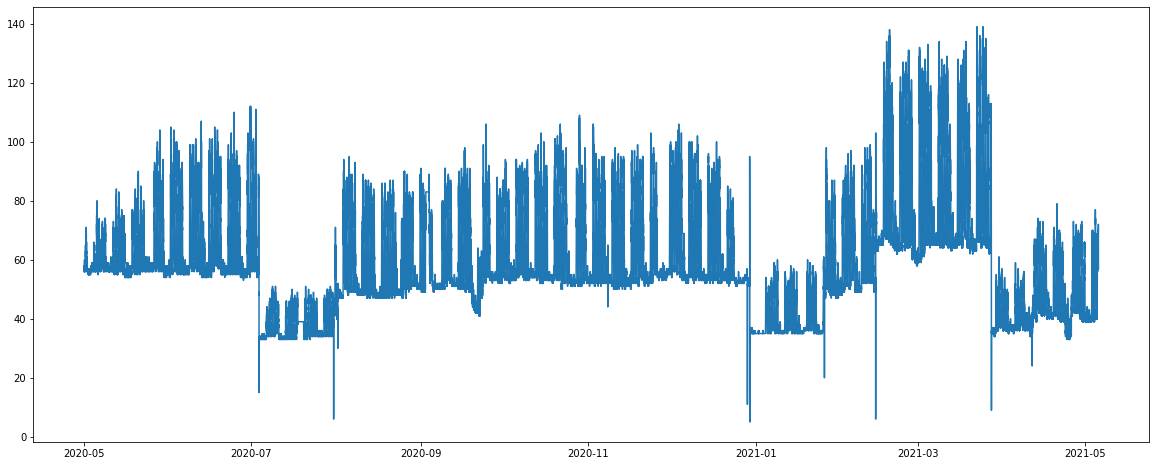

In [ ]:
plt.figure(figsize = (20,8))
#plt.plot(wifiData.sum(axis=1).ewm(span = 20).mean()[3000:5000])
#plt.plot(wifiData.sum(axis=1)[:18400])
#plt.plot(wifiTotals[69900:70000])
plt.plot(wifiTotals[:])

In [ ]:
wifi_df = pd.DataFrame(data = {"wifi":wifiTotals})
#wifiMin = pd.DataFrame(data={"daily_min":wifiTotals.groupby(wifiTotals.index.strftime('%D')).min()})
wifiMin = pd.DataFrame(data={"daily_min":wifiTotals.groupby(wifiTotals.index.date).min()})
#wifi_df.join(wifiMin, how="left", on=["key","key"])

In [ ]:
wifiMin

,daily_min
2020-04-30,56.0
2020-05-01,56.0
2020-05-02,55.0
2020-05-03,55.0
2020-05-04,56.0
...,...
2021-05-01,39.0
2021-05-02,39.0
2021-05-03,39.0
2021-05-04,39.0


In [ ]:
wifi_df["key"] = wifi_df.index.date
wifiMin["key"] = wifiMin.index
wifi_final = pd.merge(wifi_df,wifiMin, on=['key','key'])

In [ ]:
wifi_final

,wifi,key,daily_min
0,56.0,2020-04-30,56.0
1,57.0,2020-04-30,56.0
2,57.0,2020-04-30,56.0
3,56.0,2020-04-30,56.0
4,56.0,2020-04-30,56.0
...,...,...,...
106555,63.0,2021-05-05,40.0
106556,65.0,2021-05-05,40.0
106557,60.0,2021-05-05,40.0
106558,58.0,2021-05-05,40.0


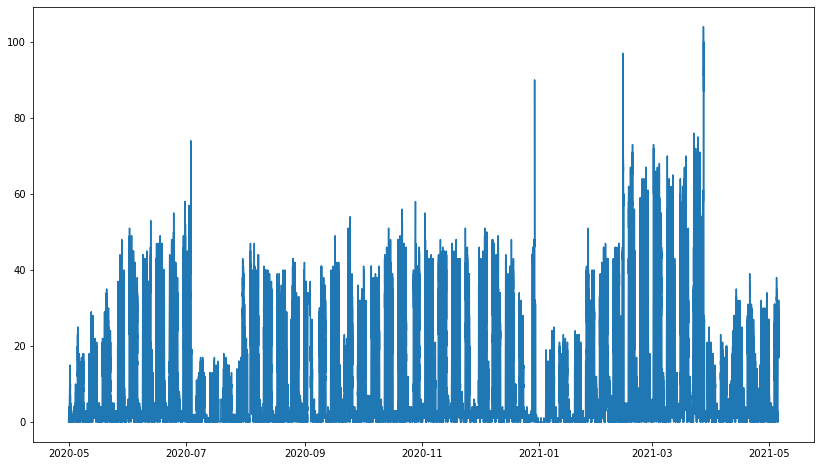

In [ ]:
wifi_final["wifi_var"] = wifi_final["wifi"] - wifi_final["daily_min"]
plt.figure(figsize=(14,8))
wifi_final.index = wifi_df.index
plt.plot(wifi_final["wifi_var"])

In [ ]:
#wifi_final.to_csv("/content/drive/My Drive/data/modelData/wifiAdjusted.csv")
wifi_final.to_pickle("/content/drive/My Drive/data/modelData/wifiAdjusted.pkl")

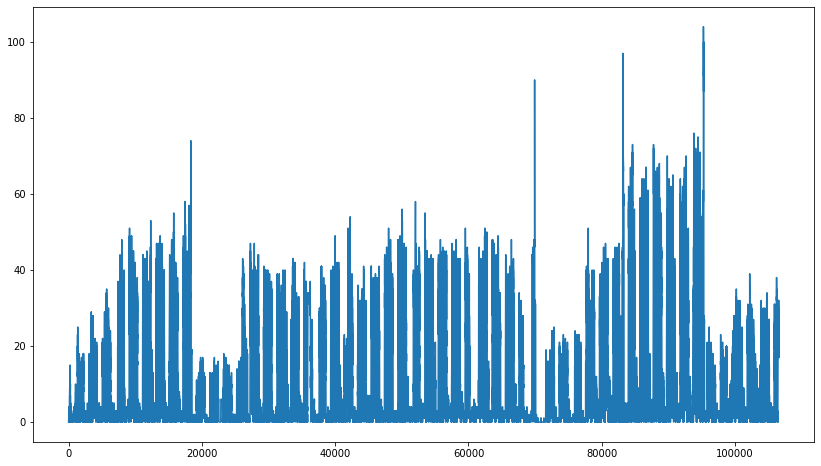

In [ ]:
plt.figure(figsize=(14,8))
#wifi_final = pd.read_csv("/content/drive/My Drive/data/modelData/wifiAdjusted.csv")
plt.plot(wifi_final["wifi_var"][:])
#wifi_final.head()

In [ ]:
wifiTotals.index.strftime('%W')[:50]

Index(['17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17',
       '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17',
       '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17',
       '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17', '17',
       '17', '17'],
      dtype='object', name='ts')

## Fumehood

In [ ]:
fumehood.diff()

Floor                         2                1       ...   2   1   2       1
Room                        225        244   145  125  ... 225 145 244 245 145
Fumehood                     81   80    93    68   56  ...  81  68  93  94  67
ts                                                     ...                    
2020-05-07 00:00:00-07:00   NaN  NaN   NaN   NaN  NaN  ... NaN NaN NaN NaN NaN
2020-05-07 00:10:00-07:00   0.0 -3.0   3.0   8.0 -4.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:20:00-07:00   0.0 -2.0  -9.0 -15.0  7.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:30:00-07:00   0.0  1.0   5.0   1.0 -5.0  ... NaN NaN NaN NaN NaN
2020-05-07 00:40:00-07:00   0.0 -2.0   7.0   9.0 -4.0  ... NaN NaN NaN NaN NaN
...                         ...  ...   ...   ...  ...  ...  ..  ..  ..  ..  ..
2021-05-07 13:10:00-07:00  70.0 -1.0 -13.0   0.0  7.0  ... NaN NaN NaN NaN NaN
2021-05-07 13:20:00-07:00   NaN -5.0   NaN  -3.0  8.0  ... NaN NaN NaN NaN NaN
2021-05-07 13:30:00-07:00   NaN  NaN   NaN   NaN  NaN  ... NaN NaN NaN NaN NaN
2021-05-07 13:40:00-07:00   NaN  NaN   NaN   NaN  NaN  ... NaN NaN NaN NaN NaN
2021-05-07 13:50:00-07:00   NaN  NaN   NaN   NaN  NaN  ... NaN NaN NaN NaN NaN

[51932 rows x 27 columns]

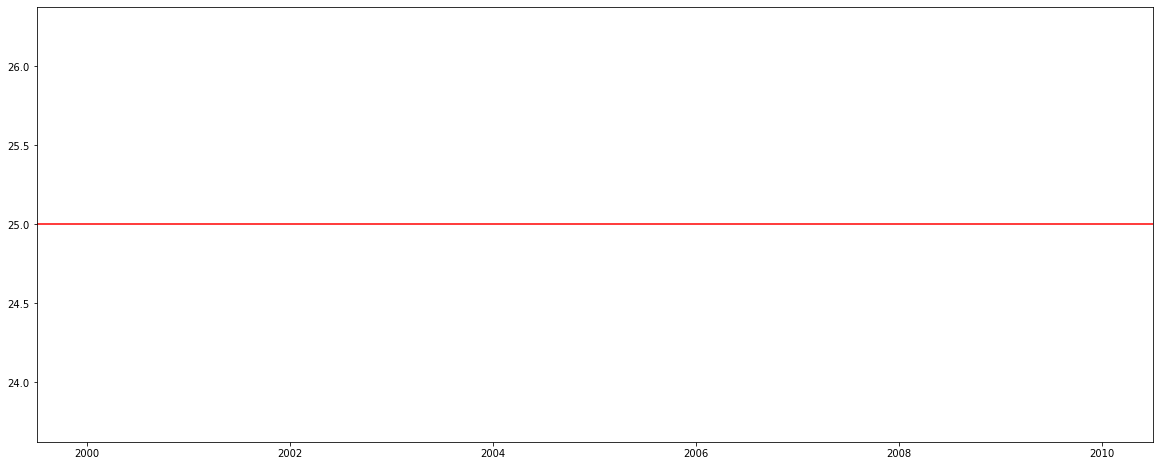

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(fumehood.iloc[:,-1][0:1000])


(0.0, 100.0)

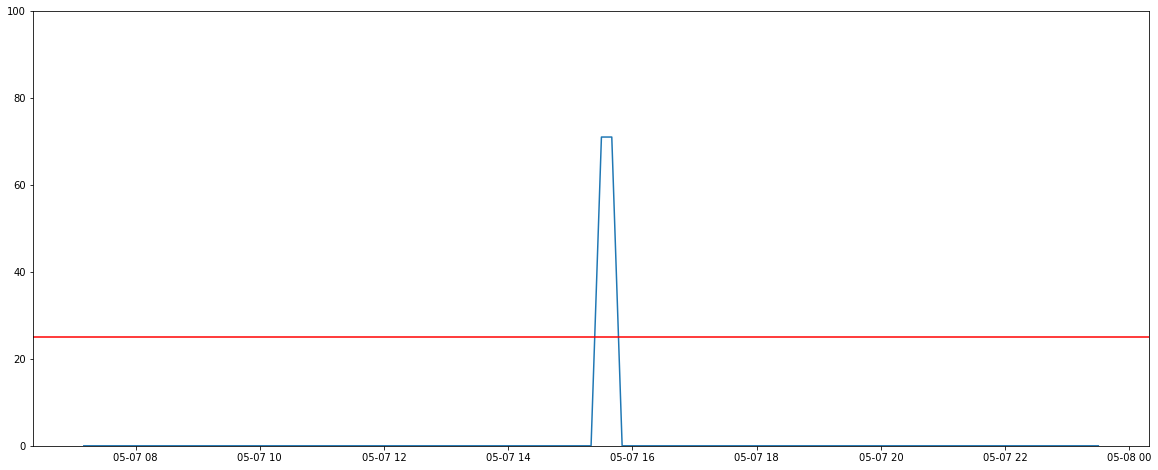

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(abs(fumehood.iloc[:,0].diff())[0:100])
plt.axhline(y=25, color='r', linestyle='-')
plt.ylim((0,100))

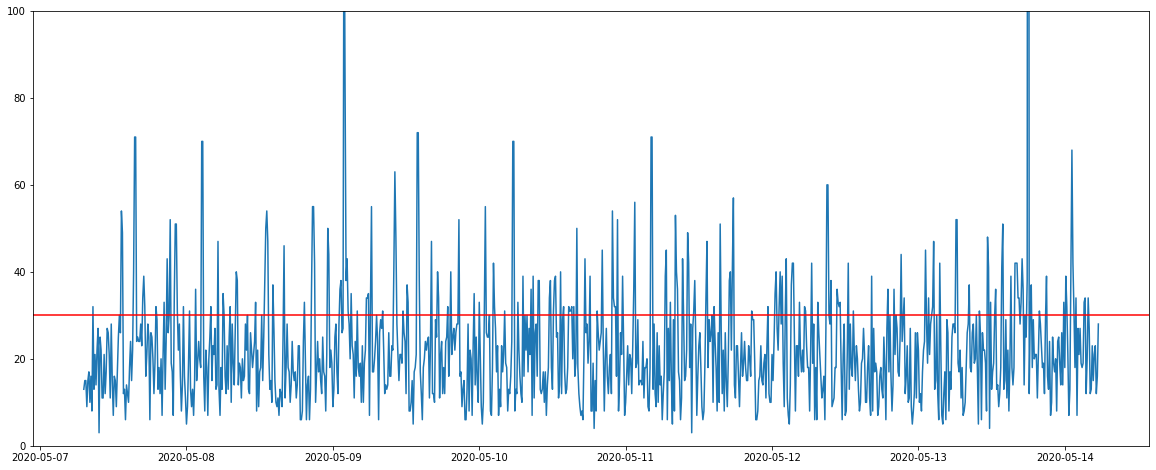

In [ ]:
#abs(fumehood.diff()).groupby(fumehood.diff().index).max()
plt.figure(figsize = (20,8))
plt.plot(abs(fumehood.diff()).max(axis=1)[0:1000])
plt.ylim((0,100))
plt.axhline(y=30, color='r', linestyle='-')

In [ ]:
fume = pd.DataFrame(abs(fumehood.diff()).max(axis=1))
fume.columns = ["max_fume_diff"]
#fume.to_csv("/content/drive/My Drive/data/modelData/fumemax.csv")
fume.to_pickle("/content/drive/My Drive/data/modelData/fumemax.pkl")

## Water Meter

                           Flow
ts                             
2020-05-18 07:45:00-07:00   NaN
2020-05-18 07:50:00-07:00   1.0
2020-05-18 07:55:00-07:00   3.0
2020-05-18 08:00:00-07:00   2.5
2020-05-18 08:05:00-07:00   0.0


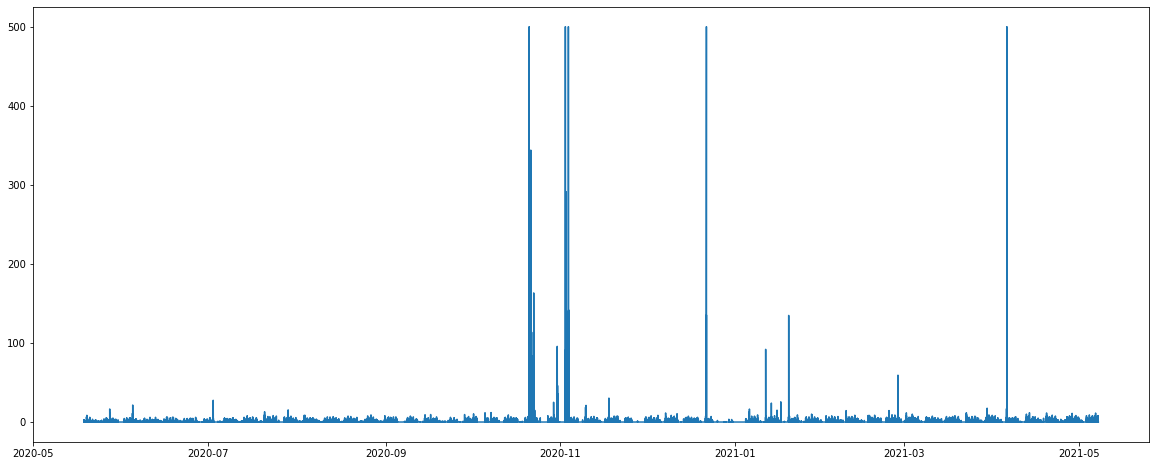

In [ ]:
waterMeter = pd.read_pickle('/content/data/cleaned/waterMeter.pkl')
print(waterMeter.head())

plt.figure(figsize = (20,8))
plt.plot(waterMeter["Flow"][0:])

In [ ]:
waterMeter["Indicator"] = [1 if x > 0 else 0 for x in waterMeter["Flow"]]
waterMeter = waterMeter.fillna(0)
waterMeter["Ind3"] = waterMeter["Indicator"].rolling(3).sum()
waterMeter["Ind3"].iloc[0] = int((sum(waterMeter["Indicator"].iloc[0:2]) > 0))
waterMeter["Ind3"].iloc[1] = int((sum(waterMeter["Indicator"].iloc[0:3]) > 0))
waterMeter["Ind3"] = [1 if x > 0. else 0 for x in waterMeter["Ind3"]]

#waterMeter.to_csv("/content/drive/My Drive/data/modelData/waterMeter.csv")
waterMeter.to_pickle("/content/drive/My Drive/data/modelData/waterMeter.pkl")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Security Events

In [ ]:
securityEvents


,Reader,Event,Floor,Room,Type
2020-05-01 13:11:13+00:00,2 230W Int,Access Granted,2,230W,Int
2020-05-01 07:04:37+00:00,2 265 Int,Access Granted,2,265,Int
2020-05-01 07:04:26+00:00,2 285 Ext,Access Granted,2,285,Ext
2020-05-01 10:46:15+00:00,3 393 Ext,Access Granted,3,393,Ext
2020-05-01 12:01:24+00:00,1 192 Ext,Access Granted,1,192,Ext
...,...,...,...,...,...
2021-05-07 07:36:11+00:00,2 285 Ext,Access Granted,2,285,Ext
2021-05-07 09:15:50+00:00,1 183 Ext,Access Granted,1,183,Ext
2021-05-07 09:08:11+00:00,1 180 Ext,Access Granted,1,180,Ext
2021-05-07 06:49:52+00:00,1 183 Ext,Access Granted,1,183,Ext


In [ ]:
securityEventsInt = securityEvents[securityEvents["Type"] == "Int"].sort_index().reset_index()
securityEventsInt["ts"] = securityEventsInt["index"].datetime.round("5min")
securityEventsInt = pd.DataFrame(securityEventsInt.groupby("ts").count()["index"])
#securityEventsInt = pd.DataFrame(securityEventsInt.set_index("ts").drop(["index","Reader","Event","Floor","Room"], axis=1).count(axis=1))
securityEventsInt.columns = ["securityInt"]
securityEventsInt["Type_Int"] = "Int"
securityEventsInt

,securityInt,Type_Int
ts,,
2020-05-01 07:05:00+00:00,1,Int
2020-05-01 08:45:00+00:00,1,Int
2020-05-01 08:50:00+00:00,1,Int
2020-05-01 09:00:00+00:00,1,Int
2020-05-01 10:15:00+00:00,1,Int
...,...,...
2021-05-07 08:30:00+00:00,1,Int
2021-05-07 08:35:00+00:00,1,Int
2021-05-07 08:40:00+00:00,1,Int


In [ ]:
securityEventsExt = securityEvents[(securityEvents["Type"] == "Ext") & (securityEvents["Event"] == "Access Granted")].sort_index().reset_index()
securityEventsExt["ts"] = securityEventsExt["index"].datetime.round("5min")
securityEventsExt = pd.DataFrame(securityEventsExt.groupby("ts").count()["index"])
#securityEventsInt = pd.DataFrame(securityEventsInt.set_index("ts").drop(["index","Reader","Event","Floor","Room"], axis=1).count(axis=1))
securityEventsExt.columns = ["securityExt"]
securityEventsExt["Type_Ext"] = "Ext"
securityEventsExt

,securityExt,Type_Ext
ts,,
2020-05-01 06:05:00+00:00,1,Ext
2020-05-01 06:25:00+00:00,1,Ext
2020-05-01 06:40:00+00:00,1,Ext
2020-05-01 06:55:00+00:00,2,Ext
2020-05-01 07:05:00+00:00,1,Ext
...,...,...
2021-05-07 08:45:00+00:00,2,Ext
2021-05-07 08:55:00+00:00,1,Ext
2021-05-07 09:05:00+00:00,1,Ext


<Figure size 1008x720 with 0 Axes>

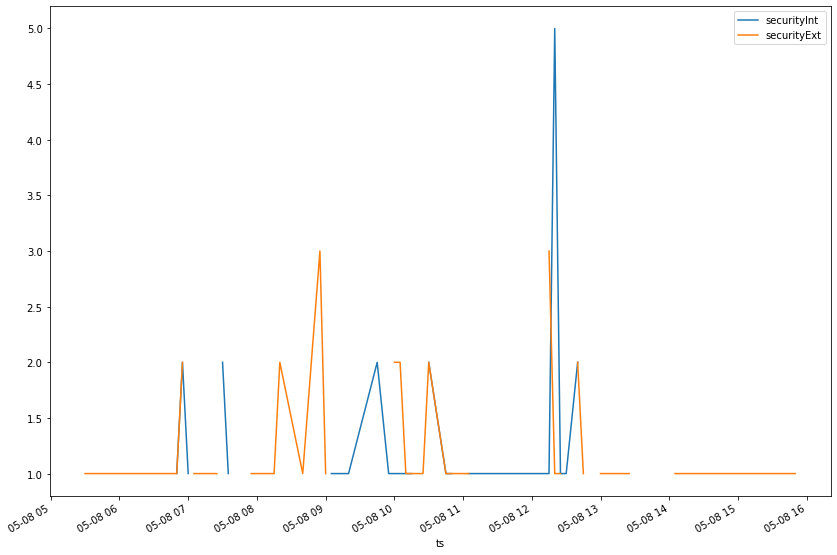

In [ ]:
securityEventsAll = securityEventsInt.join(securityEventsExt, how="outer")
#plt.plot(securityEventsAll.index, securityEventsAll.securityExt)
plt.figure(figsize = (14,10))
securityEventsAll["2020-05-08"].plot(figsize = (14,10))

In [ ]:
#allTime = pd.Series(pd.date_range(start="2020-05-01 06:05:00+00:00", end = "2021-05-07 09:15:00+00:00", freq="5T"))
#securityEventsAll.join(other = allTime, how="right")
allTime = pd.DataFrame({"ts": pd.date_range(start="2020-05-01 06:05:00+00:00", end = "2021-05-07 09:15:00+00:00", freq="5T")}).set_index("ts")
securityEventsFinal = securityEventsAll.join(other = allTime, how="right")
securityEventsFinal["Type"] = securityEventsFinal["Type_Int"].combine_first(securityEventsFinal["Type_Ext"])
securityEventsFinal

,securityInt,Type_Int,securityExt,Type_Ext,Type
ts,,,,,
2020-05-01 06:05:00+00:00,NaN,NaN,1.0,Ext,Ext
2020-05-01 06:10:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-05-01 06:15:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-05-01 06:20:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-05-01 06:25:00+00:00,NaN,NaN,1.0,Ext,Ext
...,...,...,...,...,...
2021-05-07 08:55:00+00:00,NaN,NaN,1.0,Ext,Ext
2021-05-07 09:00:00+00:00,1.0,Int,NaN,NaN,Int
2021-05-07 09:05:00+00:00,1.0,Int,1.0,Ext,Int


In [ ]:
#securityEventsFinal["Type"].iloc[1,:].first_valid_index()
securityEventsFinal["securityIndicator"] = 0
ind1 = 0
ind2 = 1
securityEventsFinal["Type"].iloc[:].first_valid_index()

Timestamp('2020-05-01 06:05:00+0000', tz='UTC', freq='5T')

In [ ]:
securityEventsFinal.index.get_loc(securityEventsFinal["Type"].iloc[2:].first_valid_index())

4

In [ ]:
#securityEventsFinal["securityIndidcator"].iloc[2:5] = 1
securityEventsFinal["securityIndicator"] = 0
ind = 0
ind2 = 1
#for ind in range(0, len(securityEventsFinal)):
while ind < len(securityEventsFinal):
  if not pd.isnull(securityEventsFinal["Type"].iloc[ind]):
    securityEventsFinal["securityIndicator"].iloc[ind] = 1
    ind += 1
  else:
    ind2 = securityEventsFinal.index.get_loc(securityEventsFinal["Type"].iloc[(ind+1):].first_valid_index())
    if securityEventsFinal["Type"].iloc[ind2] == "Int" and securityEventsFinal.index[ind].date == securityEventsFinal.index[ind2].date and securityEventsFinal.index[ind].hour > 0:
      securityEventsFinal["securityIndicator"].iloc[ind : ind2 + 1] = 1
      ind = ind2 + 1
    else:
      ind += 1
securityEventsFinal

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,securityInt,Type_Int,securityExt,Type_Ext,Type,securityIndicator,securityInd3,securityInd30
ts,,,,,,,,
2020-05-01 06:05:00+00:00,NaN,NaN,1.0,Ext,Ext,1,1.000000,1.000000
2020-05-01 06:10:00+00:00,NaN,NaN,NaN,NaN,NaN,0,0.333333,0.483333
2020-05-01 06:15:00+00:00,NaN,NaN,NaN,NaN,NaN,0,0.142857,0.311366
2020-05-01 06:20:00+00:00,NaN,NaN,NaN,NaN,NaN,0,0.066667,0.225573
2020-05-01 06:25:00+00:00,NaN,NaN,1.0,Ext,Ext,1,0.548387,0.401774
...,...,...,...,...,...,...,...,...
2021-05-07 08:55:00+00:00,NaN,NaN,1.0,Ext,Ext,1,0.750000,0.882062
2021-05-07 09:00:00+00:00,1.0,Int,NaN,NaN,Int,1,0.875000,0.889671
2021-05-07 09:05:00+00:00,1.0,Int,1.0,Ext,Int,1,0.937500,0.896789


In [ ]:
securityEventsFinal["securityInd3"] = securityEventsFinal["securityIndicator"].ewm(span = 3).mean()
securityEventsFinal["securityInd30"] = securityEventsFinal["securityIndicator"].ewm(span = 30).mean()

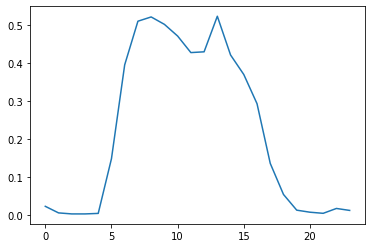

In [ ]:
plt.plot(securityEventsFinal["securityIndicator"].groupby(securityEventsFinal.index.hour).mean())

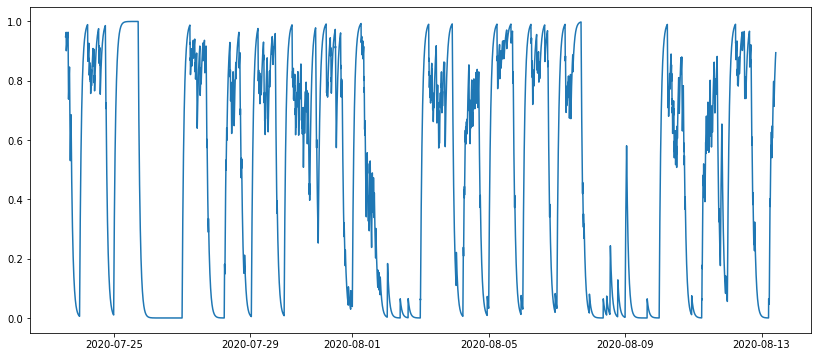

In [ ]:
plt.figure(figsize=(14,6))
#plt.plot(securityEventsFinal["securityIndicator"][24000:30000].ewm(span = 30).mean())
plt.plot(securityEventsFinal["securityInd30"][24000:30000])

In [ ]:
#securityEventsFinal.to_csv("/content/drive/My Drive/data/modelData/securityEvents.csv")
securityEventsFinal.to_pickle("/content/drive/My Drive/data/modelData/securityEvents.pkl")

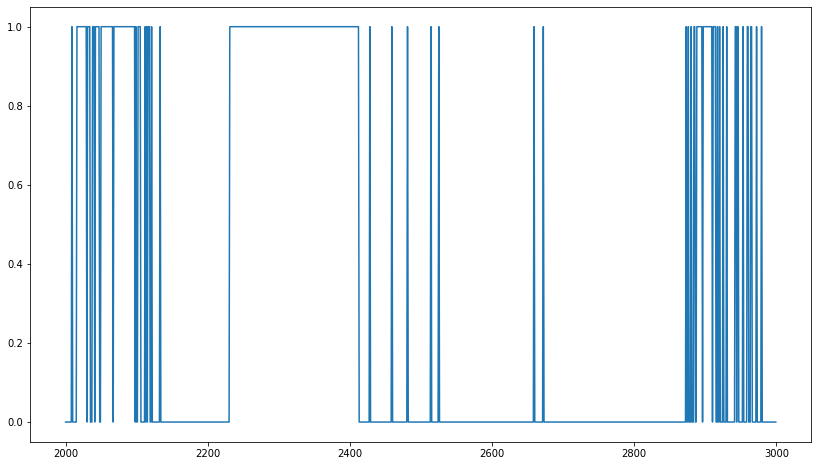

In [ ]:

security = pd.read_csv("/content/drive/My Drive/data/modelData/securityEvents.csv")
#security.index = security["ts"]
plt.figure(figsize=(14,8))
plt.plot(security["securityIndicator"][2000:3000])

## Lighting, ETC

In [ ]:
lighting = lighting.fillna(0)
lighting

Floor                                                    1  ...                          4
Room                                                   145  ...                        437
Sensor                                           006C-FCC2  ...                  0080-FFF3
Tag                       145 Open Lab OCS 008 [006C-FCC2]  ... 437 Office OCS [0080-FFF3]
ts                                                          ...                           
2020-07-07 12:20:00+00:00                              0.0  ...                        0.0
2020-07-07 12:25:00+00:00                              0.0  ...                        0.0
2020-07-07 12:30:00+00:00                              0.0  ...                        0.0
2020-07-07 12:35:00+00:00                              0.0  ...                        0.0
2020-07-07 12:40:00+00:00                              0.0  ...                        0.0
...                                                    ...  ...                        ...
2021-05-06 09:05:00+00:00                              1.0  ...                        0.0
2021-05-06 09:10:00+00:00                              1.0  ...                        0.0
2021-05-06 09:15:00+00:00                              1.0  ...                        0.0
2021-05-06 09:20:00+00:00                              0.0  ...                        0.0
2021-05-06 09:25:00+00:00                              0.0  ...                        0.0

[87230 rows x 287 columns]

In [ ]:
lightingData = pd.DataFrame(data={"lights":lighting.sum(axis = 1)})
lightingData

,lights
ts,
2020-07-07 12:20:00+00:00,16.0
2020-07-07 12:25:00+00:00,9.0
2020-07-07 12:30:00+00:00,11.0
2020-07-07 12:35:00+00:00,6.0
2020-07-07 12:40:00+00:00,46.0
...,...
2021-05-06 09:05:00+00:00,81.0
2021-05-06 09:10:00+00:00,67.0
2021-05-06 09:15:00+00:00,58.0


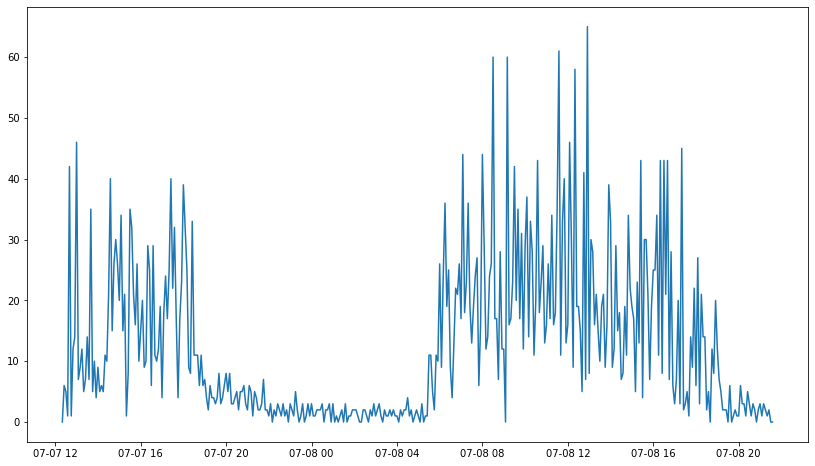

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(lighting.diff().replace(-1,0).sum(axis=1)[0:400])

In [ ]:
lighting_diff = pd.DataFrame(data={"diff":lighting.diff().replace(-1,0).sum(axis=1)})
lighting_final = lightingData.join(lighting_diff)
lighting_final

,lights,diff
ts,,
2020-07-07 12:20:00+00:00,16.0,0.0
2020-07-07 12:25:00+00:00,9.0,6.0
2020-07-07 12:30:00+00:00,11.0,5.0
2020-07-07 12:35:00+00:00,6.0,1.0
2020-07-07 12:40:00+00:00,46.0,42.0
...,...,...
2021-05-06 09:05:00+00:00,81.0,26.0
2021-05-06 09:10:00+00:00,67.0,8.0
2021-05-06 09:15:00+00:00,58.0,10.0


In [ ]:
#lighting_final.to_csv("/content/drive/My Drive/data/modelData/lighting.csv")
lighting_final.to_pickle("/content/drive/My Drive/data/modelData/lighting.pkl")

## Freezers

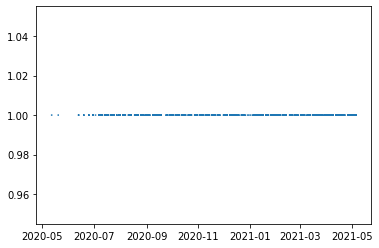

In [ ]:
plt.plot(freezers.iloc[:,1])

In [ ]:
freezers

Floor                       1       2   1   2   1  ...   2                   1
Room                      130     230 130 230 130  ... 230                 149
Freezer                    14  08  06  10  09  38  ...  20  40  25  13  33  10
ts                                                 ...                        
2020-05-06 14:40:57-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 14:45:20-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 14:45:31-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 22:39:41-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2020-05-06 22:51:20-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
...                        ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..
2021-05-05 18:31:07-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:36:44-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:36:54-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:45:29-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:45:50-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN

[129500 rows x 61 columns]

In [ ]:
freezers = freezers.fillna(0)
#freezers.diff().replace(-1,1)
freezers

Floor                        1         2    1    2  ...                        1
Room                       130       230  130  230  ...                      149
Freezer                     14   08   06   10   09  ...   40   25   13   33   10
ts                                                  ...                         
2020-05-06 14:40:57-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2020-05-06 14:45:20-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2020-05-06 14:45:31-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2020-05-06 22:39:41-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2020-05-06 22:51:20-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2021-05-05 18:31:07-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2021-05-05 18:36:44-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2021-05-05 18:36:54-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2021-05-05 18:45:29-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0
2021-05-05 18:45:50-07:00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0

[129500 rows x 61 columns]

In [ ]:
#freezers["ts"] = freezers.index.round("5min")
#freezers.index.round("5min")


In [ ]:
test_list = []
for i in range(110900,110000):
  test_list.append(freezers.index[i].round("5min"))
#freezers.index[110900:111000].round("5min")

In [ ]:
freezers.index[110000]

Timestamp('2021-03-13 10:55:03-0800', tz='US/Pacific')

In [ ]:
freezers.index[110969].round("5min")

NonExistentTimeError: ignored

In [ ]:
import time
import datetime
predst = "03/14/2021 01:55:00 -0800"
postdst = "03/14/2021 01:59:59 -0800"
predst = datetime.datetime.strptime(predst, "%m/%d/%Y %H:%M:%S %z")
postdst = datetime.datetime.strptime(postdst, "%m/%d/%Y %H:%M:%S %z")

In [ ]:
freezer_round_time = [datetime.datetime.strptime("03/14/2021 03:00:00 -0700", "%m/%d/%Y %H:%M:%S %z") if freezers.index[i] >= predst and freezers.index[i] <= postdst else \
 freezers.index[i].round("5min") for i in range(0,len(freezers))]

In [ ]:
freezer_countdf = pd.DataFrame(freezer_round_time).set_index(0)
#freezer_countdf = pd.DataFrame(freezer_countdf.groupby(0))
#freezer_countdf["freezer"] = 1

In [ ]:
freezer_test = freezer_countdf.sort_index().reset_index()
freezer_test["counts"] = 1
freezer_test.columns = ["ts", "freezer"]
freezer_join = pd.DataFrame(freezer_test.groupby("ts").count()["freezer"])

allTime = pd.DataFrame({"ts": pd.date_range(start="2020-05-01 06:05:00-07:00", end = "2021-05-07 09:15:00-07:00", freq="5T")}).set_index("ts")
freezer_df = allTime.join(freezer_join, how="left").fillna(0)

In [ ]:
freezer_df.to_pickle("/content/drive/My Drive/data/modelData/freezerCounts.pkl")

## Sound

In [ ]:
sound

Floor,2,3,4,1
Room,244,384,481,125
ts,,,,
2020-12-21 10:50:00-08:00,52.0,64.4,58.0,63.0
2020-12-21 10:55:00-08:00,61.6,61.0,63.4,61.4
2020-12-21 11:00:00-08:00,76.0,60.2,67.0,61.0
2020-12-21 11:05:00-08:00,71.4,60.0,61.4,69.0
2020-12-21 11:10:00-08:00,53.0,57.6,53.0,71.0
...,...,...,...,...
2021-05-07 09:00:00-07:00,67.0,53.0,52.0,64.0
2021-05-07 09:05:00-07:00,67.0,53.0,52.0,64.0


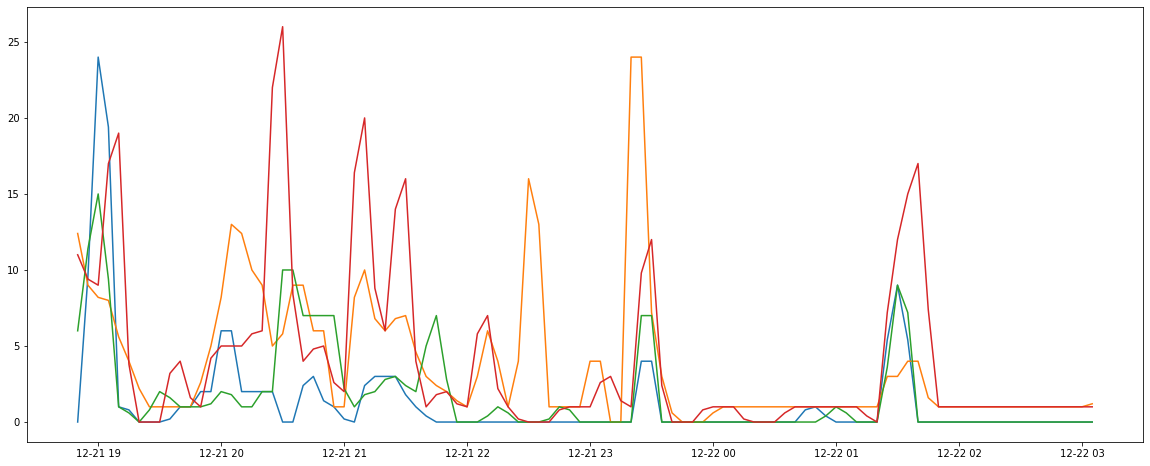

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(sound[0:100]-52)

In [ ]:
sound.min()

Floor  Room
2      244     52.0
3      384     52.0
4      481     52.0
1      125     52.0
dtype: float64

In [ ]:
plt.plot(sound-sound.groupby(sound.index.date).min())

TypeError: ignored

In [ ]:
sound_min = sound.groupby(sound.index.date).min()

In [ ]:
#sound_adj = sound.join(sound_min, how="left", on=[sound_index.date, sound_index])
sound["key"] = sound.index.date
sound_min["key"] = sound_min.index
sound_final = pd.merge(sound,sound_min, on=['key','key'])

sound_final["f2"] = sound_final["2_x"] - sound_final["2_y"]
sound_final["f3"] = sound_final["3_x"] - sound_final["3_y"]
sound_final["f4"] = sound_final["4_x"] - sound_final["4_y"]
sound_final["f1"] = sound_final["1_x"] - sound_final["1_y"]
sound_final = sound_final.set_index(sound.index)[["f2","f3","f4","f1"]]
sound_final = pd.DataFrame(sound_final.max(axis=1))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
sound_final.columns = ["sound_max"]
sound_final["sound_ind"] = [1 if sound_final["sound_max"].iloc[i] > 5 else 0 for i in range(0,len(sound_final))]

,sound_max,sound_ind
ts,,
2020-12-21 10:50:00-08:00,12.4,1
2020-12-21 10:55:00-08:00,11.4,1
2020-12-21 11:00:00-08:00,24.0,1
2020-12-21 11:05:00-08:00,19.4,1
2020-12-21 11:10:00-08:00,19.0,1
...,...,...
2021-05-07 09:00:00-07:00,1.0,0
2021-05-07 09:05:00-07:00,1.0,0
2021-05-07 09:10:00-07:00,1.0,0


In [ ]:
sound_final.to_pickle("/content/drive/My Drive/data/modelData/soundAdjusted.pkl")

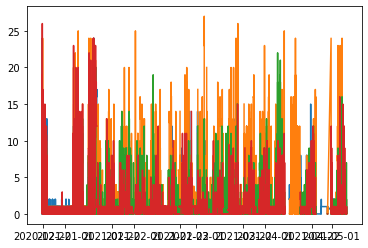

In [ ]:
plt.plot(sound_final)

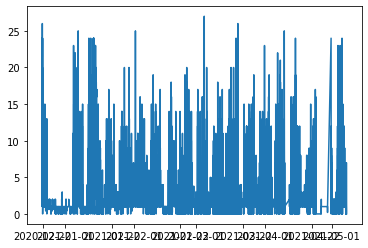